## 包的导入

In [1]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import tensorflow as tf

from tensorflow import keras
import os, sys, time 


print(sys.version_info)
for module in tf, mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)



sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
tensorflow 2.1.0
matplotlib 3.2.0
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2.post1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


## 数据集的准备
Fashion-MNIST是一个替代MNIST手写数字集的图像数据集。 它是由Zalando（一家德国的时尚科技公司）旗下的研究部门提供。其涵盖了来自10种类别的共7万个不同商品的正面图片。Fashion-MNIST的大小、格式和训练集/测试集划分与原始的MNIST完全一致。60000/10000的训练测试数据划分，28x28的灰度图片。你可以直接用它来测试你的机器学习和深度学习算法性能，且不需要改动任何的代码。
- 60000张训练图像和对应Label；
- 10000张测试图像和对应Label；
- 10个类别；
- 每张图像28x28的分辨率；

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
# fashion_mnist 训练集共有60000，将前5000作为验证集，后55000作为训练集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print("x_valid.shape, y_valid.shape:",x_valid.shape, y_valid.shape)
print("x_train.shape, y_train.shape",x_train.shape, y_train.shape)
print("x_test.shape, y_test.shape",x_test.shape, y_test.shape)

x_valid.shape, y_valid.shape: (5000, 28, 28) (5000,)
x_train.shape, y_train.shape (55000, 28, 28) (55000,)
x_test.shape, y_test.shape (10000, 28, 28) (10000,)


## 数据集样本展示

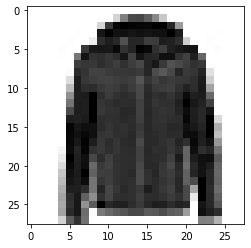

In [3]:
# 数据集样本展示
def show_single_img(img_arr):
    plt.imshow(img_arr, cmap="binary")
    plt.show()
show_single_img(x_train[0])

## 对数据进行归一化处理
> 定义：把数据经过处理后使之限定在一定的范围内。比如通常限制在区间`[0, 1]`或者`[-1, 1]`

常用归一化法：
- 最大-最小标准化: $$\frac{x-x_{min}}{x_{max}-x_{min}}$$
- Z-score标准化: $$\frac{x-\mu }{std} \left ( \mu为标准差 ,std 为方差 \right ) $$

In [4]:
'''
对数据进行归一化处理
定义：把数据经过处理后使之限定在一定的范围内。比如通常限制在区间[0, 1]或者[-1, 1]
Z-score归一化
'''
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# x_train:[None, 28, 28] -> [None, 784]
# 我们np里的数据是int类型，所以我们需要x_train.astype(np.float32)将数据转化成float32
# fit_transform 不仅有数据转化为归一化的功能，还有fit（将数据存储下来）的功能.
Z_score = lambda d:scaler.fit_transform(d.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_train_scaled = Z_score(x_train)
x_valid_scaled = Z_score(x_valid)
x_test_scaled = Z_score(x_test)

## 模型的构建
tf.keras.models.sequential()
普通的模型构建：
```
model = keras.models.Sequential([
    # 第一层输入成，每一个组数据为[28,28]的二维矩阵，通过keras.layers.Flatten压缩成一维矩阵
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation = "relu"),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(10, activation = "softmax"),
])
```

In [5]:
# 模型的构建
# tf.keras.models.sequential()
# 将 28*28 的矩阵展开为一维向量
print('训练集中第0个数据：',x_train[0].shape)
# deep_neural_network模型的构建(20层)
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100,activation='selu'))
    # 批归一化
    model.add(keras.layers.BatchNormalization())
    '''
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('selu'))
    '''
model.add(keras.layers.Dense(10,activation='softmax'))
# model = keras.models.Sequential([
#     # 第一层输入成，每一个组数据为[28,28]的二维矩阵，通过keras.layers.Flatten压缩成一维矩阵
#     keras.layers.Flatten(input_shape=[28,28]),
#     keras.layers.Dense(300, activation = "relu"),
#     keras.layers.Dense(100, activation = "relu"),
#     keras.layers.Dense(10, activation = "softmax"),
# ])
# relu: y = max(0, x)
# softmax: 将向量变成概率分布 x = [x1,x2, x3]
# y = [e^x1/sum, e^x2/sum, e^x3/sum]  sum = e^x1+e^x3+e^x3

# reason for sparse : y->index, y->one_hot->[],我们需要将y处理成one_hot向量所以用sparse
model.compile(loss="sparse_categorical_crossentropy",optimizer='sgd', metrics= ['accuracy'])
# 定义的模型中的所有层
model.layers

训练集中第0个数据： (28, 28)


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

## 数据的训练
### [添加回调函数pg](https://tensorflow.google.cn/api_docs/python/tf/keras/callbacks?hl=zh_cn)
- Tensorboard: 
    - Metrics summary plots 指标摘要图
    - Training graph visualization 训练图可视化
    - Activation histograms 激活直方图
    - Sampled profiling 采样分析
- EarlyStopping 
    - 关注某个指标，比如超参
        超参数之一是定型周期（epoch）的数量：亦即应当完整遍历数据集多少次（一次为一个epoch）？如果epoch数量太少，网络有可能发生欠拟合（即对于定型数据的学习不够充分）；如果epoch数量太多，则有可能发生过拟合（即网络对定型数据中的“噪声”而非信号拟合）。

    早停法旨在解决epoch数量需要手动设置的问题。它也可以被视为一种能够避免网络发生过拟合的正则化方法（与L1/L2权重衰减和丢弃法类似）。

    根本原因就是因为继续训练会导致测试集上的准确率下降。
    那继续训练导致测试准确率下降的原因猜测可能是1. 过拟合 2. 学习率过大导致不收敛

### 对layers进行数据训练

In [2]:
# 回调函数
logdir = './callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_modle_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_modle_file, save_best_only = True),
    # 由于epochs设置的比较小，可能不会触发，可以将epochs调大点，看看EarlyStopping的运行情况
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
# 数据的训练
history = model.fit(x_train_scaled, y_train, epochs=10,validation_data=(x_valid_scaled,y_valid))
history.history

NameError: name 'os' is not defined

## matloplib可视化

In [ ]:
# matloplib可视化
def plot_learning_cruves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()



In [ ]:
# 加上Z_scores归一化,dnn后的损失图像：
plot_learning_cruves(history)

In [ ]:
'''
### 关于梯度消失问题
深度模型中可能出现的问题：参数众多，倒只训练不充分
梯度消失问题：首先梯度下降是指，一个数按照其此点最大导数的反方向更新。
对于一个多层次的神经网络来说，比目标函数比较远的但是梯度比较微小的现象。
什么情况会导致？ 一般发生在深度模型中，根据链式法则：符合函数{f(g(x))}
梯度下降的时候我们需要对每一个嵌套的复合函数进行求导再相乘，最后如果求出来的导数小于1，多此相乘就会导致梯度消失。
1.01^99=37.8
0.99^99=0.03
'''

In [ ]:
model.evaluate(x_test_scaled, y_test)